# Comparison between observed density profiles (SUMup) and modeled density profiles (SNOWPACK and IMAU FDM)
### In the past I have computed retrieved density information (SUMup and SNOWPACK) in `Average_Density_Bins.ipynb` and plotted this information in `Density_Bias_Profile.ipynb`. In this notebook I will combine my past work to retrieve information and plot all in one place. 
### To do:
1. Turn of exclusion of density profile 10
### First import the necessary packages

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import cartopy.crs as ccrs
from pyproj import Geod
from Load_and_Process_Datasets import *

### Load in Lat/Lon/Elevation of all locations

<Figure size 432x288 with 0 Axes>

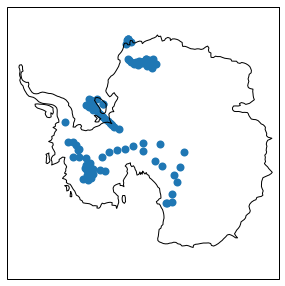

In [2]:
# Load data
lat_lon_elevation_path = "/pl/active/nasa_smb/Data/Density_Profile_Lat_Lon_Elevation.txt"
lat, lon, elevation = np.loadtxt(lat_lon_elevation_path, unpack=True)

# Plot Data
plt.figure(1)
fig1 = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines(resolution='110m')
ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
plt.scatter(lon, lat, linewidth=2, marker='o', transform=ccrs.Geodetic())

### Retrieve SUMup inforamtion

In [3]:
# Retrieve sumup data as xarray dataset
sumup_path = "/pl/active/nasa_smb/Data/SUMup_datasets_july2018_density.nc"
sumup = xr.open_dataset(sumup_path)

# Store sumup (su) xarray dataset as numpy arrays
su_lat = sumup['Latitude'].values
su_lon = sumup['Longitude'].values
su_date = sumup['Date'].values
su_density = sumup['Density'].values * 1000
su_depth = sumup['Midpoint_Depth'].values
su_error = sumup['Error'].values * 1000
su_error[su_error < 0] = np.nan
su_method = sumup['Method'].values

# Function to retrieve sumup data
def get_sumup(ds_density, ds_error, ds_method, ds_depth, ds_date, ds_lat, ds_lon, tgt_lat, tgt_lon, high, low):
    # Filter Function
    filter_func = np.vectorize(lambda lat, lon, depth: lat == tgt_lat and lon == tgt_lon \
                                  and depth >= high and depth <= low)
    # Apply filter function
    density = ds_density[filter_func(ds_lat, ds_lon, ds_depth)] # kg/m^3
    depth = ds_depth[filter_func(ds_lat, ds_lon, ds_depth)] # m
    date = ds_date[filter_func(ds_lat, ds_lon, ds_depth)]
    error = ds_error[filter_func(ds_lat, ds_lon, ds_depth)]
    method = ds_method[filter_func(ds_lat, ds_lon, ds_depth)]
    
    # Filter to only return data associated with the first timestamp
    if len(date) == 0:
        return density, depth, date, error, method
    else:
        t0 = date[0]
        filter_func = np.vectorize(lambda date: date == t0)
        density_filter = density[filter_func(date)]
        depth_filter = depth[filter_func(date)]
        date_filter = date[filter_func(date)]
        error_filter = error[filter_func(date)]
        method_filter = method[filter_func(date)]

        # Return filtered data
        return density_filter, depth_filter, date_filter, error_filter, method_filter

In [4]:
sumup['Method'][1]

<xarray.DataArray 'Method' ()>
array(3.)
Attributes:
    info:     see readme

### Retrieve IMAU FDM inforamtion

In [5]:
# Get FDM grid information
grid_txt_file = "/pl/active/nasa_smb/IMAU_FDM/Meta_Data/IN_ll_ANT27_RACMO2.4_nor_NEW.txt"
grid_lon, grid_lat = np.loadtxt(grid_txt_file, delimiter = ",", usecols = (0,1), unpack=True)

# Function to retrieve FDM data
def get_FDM(tgt_lat, tgt_lon, tgt_date, high, low):
#     Find grid cell closest to taget lat/lon
######### New Method
    distance = np.zeros(len(grid_lat)); distance[:] = np.nan
    wgs84_geod = Geod(ellps='WGS84')
    for j in range(0, len(distance)):
        az12,az21,distance[j] = wgs84_geod.inv(tgt_lon,tgt_lat,grid_lon[j],grid_lat[j])
    tgt_index = np.argmin(distance)
    print("   FDM index " + str(tgt_index + 1))
    print("   FDM distance from obs " + str(distance[tgt_index] / 1000))
    print("   FDM Lat " + str(grid_lat[tgt_index]))
    print("   FDM Lon " + str(grid_lon[tgt_index]))
######### Old Method
#     delta_lat = tgt_lat - grid_lat
#     delta_lon = tgt_lon - grid_lon
#     delta_lat_lon = np.sqrt(np.power(delta_lat, 2) + np.power(delta_lon, 2))
#     tgt_index = np.argmin(delta_lat_lon)
#     print(tgt_index + 1)
    
    # Path and data retrieval
    FDM_path = "/pl/active/nasa_smb/IMAU_FDM/Data/ECMWF_ANT27_aprun_final_2Ddetail_" + str(tgt_index + 1) + ".nc"
    FDM = xr.open_dataset(FDM_path)

    # Timeseries (Antarctic FDM starts on 1979-01-01 and has 10 daily temporal resolution)
    number_timesteps = len(FDM['time'])
    time = pd.date_range('1979-01-01', periods = number_timesteps, freq = '10D')
    
    # Retrieve and print time
    index = np.argmin(np.abs(tgt_date - time))
    timestamp = time[index]

    # Retrieve data at that time
    FDM_density_timestamp = FDM['dens'][:, index].values
    depth = FDM['depth'].values
    
    # Filter data to vertical specfification
    filter_func = np.vectorize(lambda depth: depth >= high and depth <= low)
    FDM_density_timestamp = FDM_density_timestamp[filter_func(depth)] # kg/m^3
    depth = depth[filter_func(depth)]
    
    # Return filtered data
    return FDM_density_timestamp, depth, timestamp

### Retrieve SNOWPACK inforamtion

In [6]:
# Snowpack path
# snowpack_path = "/projects/erke2265/1D_Snowpack/Simulations/density_profile/density_profile_"
snowpack_path = "/pl/active/nasa_smb/simulations/up_to_date_simulations/density_profile_10mfl_ov_rr/density_profile_"

# Function to retrieve Snowpack data
def get_snowpack(tgt_lat, tgt_lon, tgt_date, high, low, index):
    
    # profile path
    profile_path = snowpack_path + str(index + 1) + "/output/LAT" + str(tgt_lat) + "LON" + str(tgt_lon) + ".pro"
    
#     # Get model data (old method)
#     density_mod, depth_mod = snwpck_1D.get_profile_timestamp(profile_path, '0502', tgt_date)
    
    # Get model data (new method)
    !bash postprocess.sh {profile_path} {timestamp_shell} > pro_data.txt
    depth_mod, density_mod = np.loadtxt("pro_data.txt", usecols=(2, 5), unpack=True)

    # Return filtered data
    return density_mod, depth_mod



### Execute Retrievals

In [7]:
# Create .txt file for sumup dates
f= open("/pl/active/nasa_smb/simulations/up_to_date_simulations/density_profile_10mfl_ov_rr/sumup_date.txt","w")

# Create dictionary
density_profile = {}

# Loop through every geographic point
for j in range(0, len(lat)):
# for j in range(0, 10):
    print("Working on site " + str(j+1) + " of " + str(len(lat)))
    # Retrieval filter parameters
    tgt_lat = lat[j]
    tgt_lon = lon[j]
    high = 0 # Surface
    low = 10 # 10 m depth
    print("   tgt lat " + str(tgt_lat))
    print("   tgt lon " + str(tgt_lon))
    
    # String names
    sumup_depth_str = "sumup_depth_" + str(j + 1) 
    sumup_density_str = "sumup_density_" + str(j + 1)
    sumup_error_str = "sumup_error_" + str(j + 1)
    sumup_date_str = "sumup_date_" + str(j + 1)
    fdm_depth_str = "fdm_depth_" + str(j + 1) 
    fdm_density_str = "fdm_density_" + str(j + 1)
    snowpack_depth_str = "snowpack_depth_" + str(j + 1) 
    snowpack_density_str = "snowpack_density_" + str(j + 1)
    
    # SUMup
    print("   SUMup" )
    obs_density, obs_depth, obs_date, obs_error, obs_method = \
        get_sumup(su_density, su_error, su_method, su_depth, su_date, su_lat, su_lon, tgt_lat, tgt_lon, high, low)
    density_profile[sumup_depth_str] = obs_depth
    density_profile[sumup_density_str] = obs_density
    density_profile[sumup_date_str] = obs_date
    density_profile[sumup_error_str] = obs_error

    # If there are no observations, take no model data
    if len(obs_density) == 0:
        print("      No obs!")
        density_profile[fdm_depth_str] = []
        density_profile[fdm_density_str] = []
        density_profile[snowpack_depth_str] = []
        density_profile[snowpack_density_str] = []
#         f.write("NaN\n")
    
    # If there are observations, retrieve model data
    else:
        # Get observations timestamp
        tmp_str = str(obs_date[0])
        year = tmp_str[0:4]
        month = tmp_str[4:6]
        day = tmp_str[6:8]
        if month == "00":
            month = "01"
        elif month == "90":
            month = "01"
        if day == "00":
            day = "01"
        timestamp = year + "-" + month + "-" + day + " 12:00:00"
        timestamp_shell = year + "-" + month + "-" + day
        tgt_date = pd.to_datetime(timestamp)
        print("   " + str(timestamp_shell))
#         f.write(year + "-" + month + "-" + day + "\n")
        
        # FDM
        print("   FDM" )
        fdm_density, fdm_depth, fdm_date = get_FDM(tgt_lat, tgt_lon, tgt_date, high, low)
        density_profile[fdm_depth_str] = fdm_depth
        density_profile[fdm_density_str] = fdm_density

        # SNOWPACK
        print("   SNOWPACK" )
        snowpack_density, snowpack_depth = get_snowpack(tgt_lat, tgt_lon, timestamp_shell, high, low, j)
        density_profile[snowpack_depth_str] = snowpack_depth
        density_profile[snowpack_density_str] = snowpack_density  
f.close()
        

Working on site 1 of 124
   tgt lat -89.9333
   tgt lon 144.3938
   SUMup
   2002-01-01
   FDM
   FDM index 8234
   FDM distance from obs 7.449988402571542
   FDM Lat -90.0
   FDM Lon -170.0
   SNOWPACK
Working on site 2 of 124
   tgt lat -88.5095
   tgt lon 178.5308
   SUMup
   2007-01-01
   FDM
   FDM index 7253
   FDM distance from obs 6.7920476593851475
   FDM Lat -88.4793
   FDM Lon -179.4602
   SNOWPACK
Working on site 3 of 124
   tgt lat -88.0022
   tgt lon -107.9833
   SUMup
   2002-01-01
   FDM
   FDM index 7572
   FDM distance from obs 7.191013677882909
   FDM Lat -87.9845
   FDM Lon -109.7512
   SNOWPACK
Working on site 4 of 124
   tgt lat -86.84
   tgt lon 95.31
   SUMup
   2003-01-01
   FDM
   FDM index 8413
   FDM distance from obs 11.270099996095066
   FDM Lat -86.7404
   FDM Lon 95.5989
   SNOWPACK
Working on site 5 of 124
   tgt lat -86.5025
   tgt lon -107.9903
   SUMup
   2002-01-01
   FDM
   FDM index 7078
   FDM distance from obs 15.760639140560938
   FDM Lat -86.5

   2011-12-23
   FDM
   FDM index 3997
   FDM distance from obs 10.034962171740544
   FDM Lat -78.9139
   FDM Lon -116.0669
   SNOWPACK
Working on site 41 of 124
   tgt lat -78.733
   tgt lon -111.4966
   SUMup
   2000-01-01
   FDM
   FDM index 4458
   FDM distance from obs 17.168029628672542
   FDM Lat -78.6949
   FDM Lon -110.7356
   SNOWPACK
Working on site 42 of 124
   tgt lat -78.728
   tgt lon -114.7322
   SUMup
   2011-12-14
   FDM
   FDM index 3996
   FDM distance from obs 13.18317216462364
   FDM Lat -78.7109
   FDM Lon -115.3293
   SNOWPACK
Working on site 43 of 124
   tgt lat -78.60611
   tgt lon -55.43167
   SUMup
   1984-01-28
   FDM
   FDM index 11459
   FDM distance from obs 13.402613674829663
   FDM Lat -78.4866
   FDM Lon -55.4885
   SNOWPACK
Working on site 44 of 124
   tgt lat -78.433
   tgt lon -115.9172
   SUMup
   2000-01-01
   FDM
   FDM index 3846
   FDM distance from obs 9.82867104484657
   FDM Lat -78.3641
   FDM Lon -115.6448
   SNOWPACK
Working on site 45 of

   2006-01-04
   FDM
   FDM index 16429
   FDM distance from obs 13.42767983357409
   FDM Lat -75.1983
   FDM Lon 5.2634
   SNOWPACK
Working on site 80 of 124
   tgt lat -75.236252
   tgt lon 3.424011
   SUMup
   2006-01-03
   FDM
   FDM index 16427
   FDM distance from obs 9.829310916318686
   FDM Lat -75.1488
   FDM Lon 3.3836
   SNOWPACK
Working on site 81 of 124
   tgt lat -75.231415
   tgt lon 2.713953
   SUMup
   2006-01-03
   FDM
   FDM index 16426
   FDM distance from obs 14.750331785598256
   FDM Lat -75.118
   FDM Lon 2.449
   SNOWPACK
Working on site 82 of 124
   tgt lat -75.227753
   tgt lon 7.655268
   SUMup
   2006-01-06
   FDM
   FDM index 16432
   FDM distance from obs 12.797647912524264
   FDM Lat -75.2417
   FDM Lon 8.1016
   SNOWPACK
Working on site 83 of 124
   tgt lat -75.227386
   tgt lon 4.131404
   SUMup
   2006-01-04
   FDM
   FDM index 16428
   FDM distance from obs 7.933158929949152
   FDM Lat -75.1756
   FDM Lon 4.3219
   SNOWPACK
Working on site 84 of 124
 

   2002-01-02
   FDM
   FDM index 17515
   FDM distance from obs 10.780863701375129
   FDM Lat -71.3673
   FDM Lon -9.7499
   SNOWPACK
Working on site 120 of 124
   tgt lat -71.214361
   tgt lon -6.793861
   SUMup
   2002-01-02
   FDM
   FDM index 17691
   FDM distance from obs 12.94040528567666
   FDM Lat -71.2051
   FDM Lon -6.4352
   SNOWPACK
Working on site 121 of 124
   tgt lat -70.706667
   tgt lon -8.426667
   SUMup
   1997-12-04
   FDM
   FDM index 17765
   FDM distance from obs 7.101807813281313
   FDM Lat -70.744
   FDM Lon -8.2706
   SNOWPACK
Working on site 122 of 124
   tgt lat -70.65861
   tgt lon -8.2525
   SUMup
   1989-12-27
   FDM
   FDM index 17765
   FDM distance from obs 9.55041028473329
   FDM Lat -70.744
   FDM Lon -8.2706
   SNOWPACK
Working on site 123 of 124
   tgt lat -70.655692
   tgt lon -8.253632
   SUMup
   2002-01-03
   FDM
   FDM index 17765
   FDM distance from obs 9.872467031240385
   FDM Lat -70.744
   FDM Lon -8.2706
   SNOWPACK
Working on site 124 

# Test postprocess.sh

### Save information into a pickle file

In [8]:
# Create a pickle file
f = open("density_profile_10mfl_ov_rr.pkl","wb")
pickle.dump(density_profile,f)
f.close()